## Import Dependancies

In [1]:
#scraping tools
from urllib.error import HTTPError
from datetime import datetime
import json
from bs4 import BeautifulSoup as bs
import pandas as pd
import os
import numpy as np
import requests

# NLP tools
import pandas as pd
from collections import Counter
import re
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

#import API key
from keys import magic_key

#viz tools
import matplotlib.pyplot as plt
import seaborn as sns

### Get YouTube Transcript (Currently Broken)

Apparently you can't scrape the transcripts the old fashioned way. 

In [2]:
# print("Drop in the link to the youtube video.")
# url = input()

# # https://www.youtube.com/watch?v=jCZKEnThrjI

In [3]:
# print (f'Your url is {url}')
# with request.urlopen(url) as response:
#     resp = response.read()
#     soup = bs(resp, "html.parser")
#     print("Your youtube soup is ready!")

In [4]:
# print(soup)

In [5]:
# #pull in title and transcript from the soup
# lil_soup = soup.find_all("div", id_="segments-container")
# print(lil_soup)

### Functions that Returns Youtube Comments
Uses the Youtube API

In [6]:
#function for getting Youtube comments with the Youtube API
def get_comments():
    
    #get the parameters url from the user and create a 
    video_url = input("Drop in the Youtube Link: ")
    print ('Got it! Thanks')
    video_id = video_url[32:] #extract the video id from the url
    # print(video_id)
    
    # init API query
    comment_url = f"https://www.googleapis.com/youtube/v3/commentThreads?key={magic_key}"
    params = f"&textFormat=plainText&part=snippet&videoId={video_id}&maxResults=300"
    title_url = f'https://youtube.googleapis.com/youtube/v3/videos?part=snippet&id={video_id}&key={magic_key}'
    
    # 1ST API CALL
    response = requests.get(title_url).json()
    video_title = response['items'][0]['snippet']['title']
    
    # 2ND API CALL
    query_url = comment_url + params
    response = requests.get(query_url).json()
    
    
    # LOOP THRU COMMENTS AND GET THAT YUMMY COMMENT TEXT
    # response['items'][10] # this is the format of a SINGLE COMM
    #raw_comment_list = response['items']

    num_comments = response['pageInfo']['totalResults'] # number of comments acutally returned from API
    counter = np.arange(0,num_comments) # create list to count thru
    print(f'We found {num_comments} comments for {video_title}.')

    comments = [video_title]
    for c in counter:
        comment_text = response['items'][c]['snippet']['topLevelComment']['snippet']['textOriginal']
        #print(comment_text)
        #print('------------------')
        comments.append(comment_text)
        
    return comments

In [7]:
# testing function
comments = get_comments()

Drop in the Youtube Link: https://www.youtube.com/watch?v=jCZKEnThrjI&t=7s
Got it! Thanks
We found 100 comments for The Good Death's Caitlin Doughty Talks Money, Fear, Death, and Awesome Bangs.


### Functions to Determine Sentiment

In [8]:
def get_sentimental(string_list):
    sia = SentimentIntensityAnalyzer()

    #init lists
    text = []
    neg_score = []
    neu_score = []
    pos_score = []
    compound_score = []

    for string in string_list[1:]:
        siaOut = sia.polarity_scores(string)

        text.append(string)
        neg_score.append(siaOut['neg'])
        neu_score.append(siaOut['neu'])
        pos_score.append(siaOut['pos'])
        compound_score.append(siaOut['compound'])

    #     print(comment)
    #     print(siaOut)
    #     print('-------------')

    # create a dataframe of the comments and their sentiments
    df = pd.DataFrame({'text': text,
                       'neg_score': neg_score,
                       'neu_score': neu_score,
                       'pos_score': pos_score,
                       'compound_score': compound_score
                      })
    df['video_title'] = string_list[0]
    
    return df

In [9]:
def main():
    comments = get_comments()
    df = get_sentimental(comments)
    
    return df

In [10]:
main()

Drop in the Youtube Link: https://www.youtube.com/watch?v=jCZKEnThrjI&t=7s
Got it! Thanks
We found 100 comments for The Good Death's Caitlin Doughty Talks Money, Fear, Death, and Awesome Bangs.


,text,neg_score,neu_score,pos_score,compound_score,video_title
0,In this episode of The Financial Diet Chelsea'...,0.163,0.739,0.098,-0.5803,"The Good Death's Caitlin Doughty Talks Money, ..."
1,1:07:13 the fact that this was recorded in Dec...,0.000,1.000,0.000,0.0000,"The Good Death's Caitlin Doughty Talks Money, ..."
2,She looks like liv Tyler,0.000,0.615,0.385,0.3612,"The Good Death's Caitlin Doughty Talks Money, ..."
3,Love you both!,0.000,0.308,0.692,0.6696,"The Good Death's Caitlin Doughty Talks Money, ..."
4,My mother is 72 and created an advanced direct...,0.080,0.739,0.181,0.7579,"The Good Death's Caitlin Doughty Talks Money, ..."
...,...,...,...,...,...,...
95,My grandma always says “I don’t have to do any...,0.056,0.776,0.168,0.6310,"The Good Death's Caitlin Doughty Talks Money, ..."
96,'Do you want bangs or do you need to go to the...,0.000,0.777,0.223,0.5106,"The Good Death's Caitlin Doughty Talks Money, ..."
97,At the funeral home I just quit from the avera...,0.200,0.800,0.000,-0.6124,"The Good Death's Caitlin Doughty Talks Money, ..."
98,"The thing I have heard mentioned is, once you ...",0.000,0.808,0.192,0.9345,"The Good Death's Caitlin Doughty Talks Money, ..."


## Positive Comment Test

In [11]:
# test on video with positive comments
# https://www.youtube.com/watch?v=jCZKEnThrjI&t=7s (Caitlin Doughty and Chelsea Fagan Podcast)

test = main()

Drop in the Youtube Link: https://www.youtube.com/watch?v=jCZKEnThrjI&t=7s
Got it! Thanks
We found 100 comments for The Good Death's Caitlin Doughty Talks Money, Fear, Death, and Awesome Bangs.


In [12]:
print(f'Average Compound Score {test.compound_score.mean()}')

Average Compound Score 0.270128


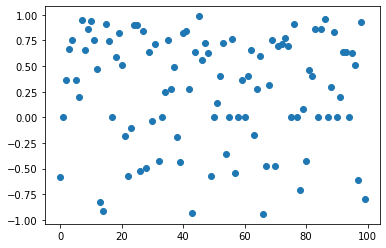

In [13]:
# scatterplot test (NOT GREAT)
plt.scatter(test.index, test.compound_score)

<AxesSubplot:xlabel='compound_score'>

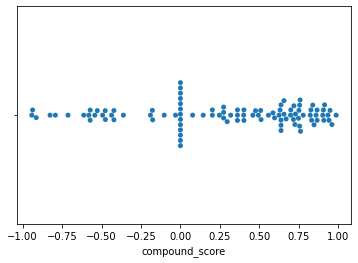

In [14]:
# swarmplot test (BETTER)
sns.swarmplot(x=test.compound_score)

<AxesSubplot:ylabel='Density'>

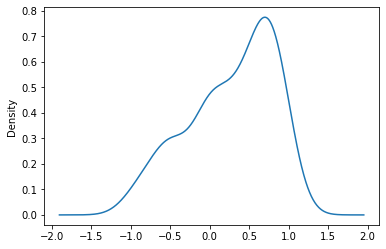

In [15]:
#density plot (WHAT IS THIS EVEN)
test.compound_score.plot(kind='density')

<AxesSubplot:xlabel='compound_score'>

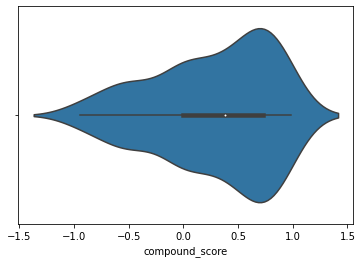

In [16]:
#violinplot test (I LIKE IT BUT NEED MORE INFO)
sns.violinplot(x=test.compound_score)

(array([ 5.,  5.,  8.,  4., 15.,  4., 12.,  8., 22., 17.]),
 array([-0.9416 , -0.74881, -0.55602, -0.36323, -0.17044,  0.02235,
         0.21514,  0.40793,  0.60072,  0.79351,  0.9863 ]),
 <BarContainer object of 10 artists>)

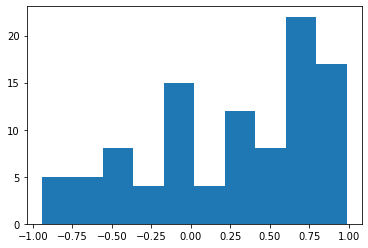

In [17]:
#histogram test
plt.hist(test.compound_score)

## Negative Comment Test

In [18]:
# test on video with positive comments
# https://www.youtube.com/watch?v=YbJOTdZBX1g&t (2018 Youtube Rewind)

test_2 = main()

Drop in the Youtube Link: https://www.youtube.com/watch?v=YbJOTdZBX1g
Got it! Thanks
We found 100 comments for YouTube Rewind 2018: Everyone Controls Rewind | #YouTubeRewind.


In [19]:
print(f'Average Compound Score {test_2.compound_score.mean()}')

Average Compound Score -0.14402600000000002


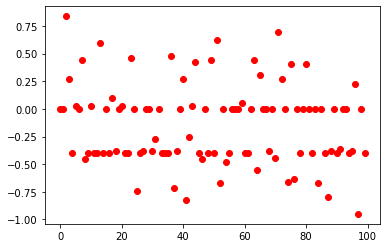

In [20]:
# scatterplot test (NOT GREAT)
plt.scatter(test_2.index, test_2.compound_score, color='r')

<AxesSubplot:xlabel='compound_score'>

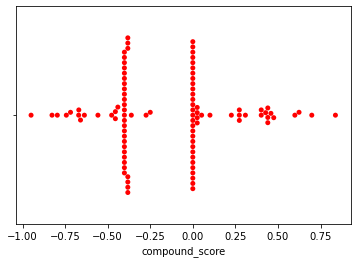

In [21]:
# swarmplot test (BETTER)
sns.swarmplot(x=test_2.compound_score, color='r')

<AxesSubplot:ylabel='Density'>

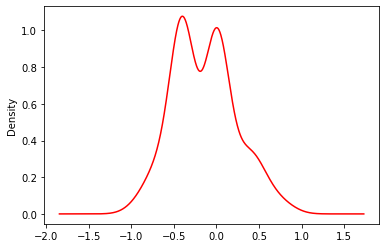

In [22]:
#density plot (WHAT IS THIS EVEN)
test_2.compound_score.plot(kind='density',color='r')

<AxesSubplot:xlabel='compound_score'>

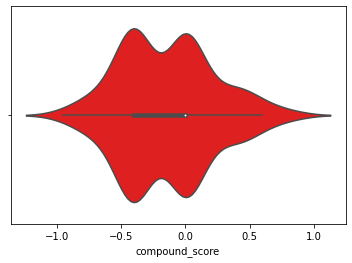

In [23]:
#violinplot test (I LIKE IT BUT NEED MORE INFO)
sns.violinplot(x=test_2.compound_score, color='r')

(array([ 3.,  6.,  5., 34.,  0., 35.,  4.,  9.,  2.,  2.]),
 array([-0.9501 , -0.77132, -0.59254, -0.41376, -0.23498, -0.0562 ,
         0.12258,  0.30136,  0.48014,  0.65892,  0.8377 ]),
 <BarContainer object of 10 artists>)

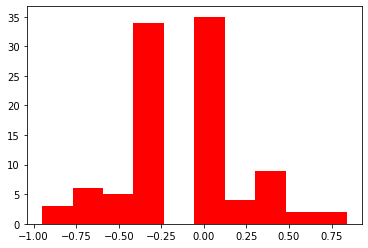

In [24]:
#histogram test
plt.hist(test_2.compound_score, color='r')

## Comparing the Two Videos

In [32]:
compare_df = pd.concat([test,test_2])

In [33]:
compare_df['dummy'] = 0

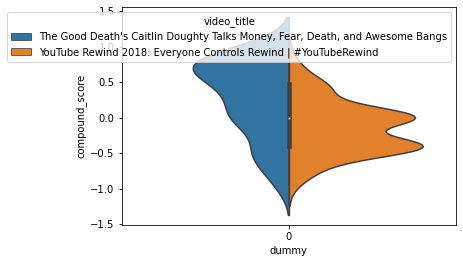

In [34]:
plot = sns.violinplot(data=compare_df, y='compound_score', split=True, hue='video_title', x='dummy')
picture = plot.get_figure()
picture.savefig('output.png')

### Tokenize Document

In [30]:
file = "Resources/Corpus_Podcast"

In [31]:
with open(file) as f:
    raw_text = f.readlines()

FileNotFoundError: [Errno 2] No such file or directory: 'Resources/Corpus_Podcast'

In [ ]:
def to_tokens(dirty_text):
    
    big_string = ' '.join(dirty_text).lower() # join and lower into big string
    big_string = re.sub(r"[^a-z0-9'\s]", '', big_string) #drop punctuation
    big_string = re.sub(r'\d+', '', big_string) # remove numbers
    
    tokens = nltk.word_tokenize(big_string) # tokenize with nltk
    print(f'Your text is now {len(tokens)} tokens.')
    
    print("Drop it like it's stop.")
    #loop thru words and strip stop words
    cleaned_words = []
    for token in tokens:
        if token not in stopwords.words('english'):
            cleaned_words.append(token)
            
    print(f'Now your text is only {len(cleaned_words)} tokens.')
    
    return tokens

In [ ]:
tokens = to_tokens(raw_text)
tokens

In [ ]:
def score_text(dirty_text):
    
    big_string = ' '.join(dirty_text).lower() # join and lower into big string
    big_string = big_string.replace('.','').replace(',','') #drop commas and periods
    
    sia = SentimentIntensityAnalyzer()
    siaOut = sia.polarity_scores(big_string)
    print(siaOut)

In [ ]:
score_text(tokens)

In [ ]:
score_text(raw_text)